# Movie ratings - NMF model

In this notebook I will build a NMF model for movie rating prediction.

First I will import the required libraries and load the data. I will only need the train and test sets for the ratings.

In [94]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load the data
train = pd.read_csv('movie_ratings/train.csv')
test = pd.read_csv('movie_ratings/test.csv')

train.head()

,uID,mID,rating
0,744,1210,5
1,3040,1584,4
2,1451,1293,5
3,5455,3176,2
4,2507,3074,5


Next, I will create the user-item matrix, based on train data.

In [95]:
user_item_matrix = train.pivot_table(index='uID', columns='mID', values='rating')

For the NMF model to work correctly, I will need to ensure that all movies from the test set are also included in the matrix:

In [96]:
missing_cols = list(set(test['mID']) - set(train['mID']))
for col in missing_cols:
    user_item_matrix[col] = [None] * len(user_item_matrix)

I will need to fill all NaN cells with values. Otherwise the NMF model will not work. I will fill those cells with user average rating:

In [97]:
import warnings
warnings.filterwarnings("ignore") # ignore downcasting warnings

user_item_matrix = user_item_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

Now I can build the NMF model

In [103]:
nmf = NMF(n_components=50)
user_matrix = nmf.fit_transform(user_item_matrix)
item_matrix = nmf.components_

To get all ratings predictions I will multiply W and H matrices. I will also clip the values to be between 1 and 5. The results will be stored in a dataframe

In [99]:
# predict the ratings
preds = user_matrix.dot(item_matrix)
# clip the values to be between 1 and 5
preds[preds > 5] = 5
preds[preds < 1] = 1
preds = pd.DataFrame(preds, columns=user_item_matrix.columns, index=user_item_matrix.index)

preds.head()

mID,1,2,3,4,5,6,7,8,9,10,...,868,3172,872,3305,624,3315,884,887,3065,3323
uID,,,,,,,,,,,,,,,,,,,,,
1,4.288054,4.217755,4.213402,4.203071,4.214910,4.200221,4.237013,4.216660,4.210625,4.231669,...,4.214013,4.214013,4.214013,4.214013,4.214013,4.214013,4.214013,4.214013,4.214013,4.214013
2,3.717930,3.604074,3.618764,3.656508,3.660293,3.688673,3.665811,3.635717,3.652719,3.613970,...,3.648679,3.648679,3.648679,3.648679,3.648679,3.648679,3.648679,3.648679,3.648679,3.648679
3,3.800443,3.894503,3.902968,3.918843,3.908245,3.880092,3.900772,3.923846,3.910767,3.961555,...,3.921161,3.921161,3.921161,3.921161,3.921161,3.921161,3.921161,3.921161,3.921161,3.921161
4,3.996992,3.909254,3.919673,3.926596,3.925820,3.909011,3.926929,3.928128,3.934672,3.929580,...,3.932229,3.932229,3.932229,3.932229,3.932229,3.932229,3.932229,3.932229,3.932229,3.932229
5,3.460350,3.092495,3.136976,3.099705,3.115108,3.133494,3.082242,3.126793,3.129074,3.062527,...,3.139234,3.139234,3.139234,3.139234,3.139234,3.139234,3.139234,3.139234,3.139234,3.139234


Now I can get a list of predictions for train and test sets

In [100]:
train_pred_ratings = []
for _, row in train.iterrows():
    train_pred_ratings.append(preds.loc[row['uID'], row['mID']])


test_pred_ratings = []
for _, row in test.iterrows():
    test_pred_ratings.append(preds.loc[row['uID'], row['mID']])

And finally, I will calculate the RMSE for train and test sets:

In [101]:
# RMSE on the training set
rmse = sqrt(mean_squared_error(train['rating'], train_pred_ratings))
print(rmse)

# RMSE on the test set
rmse = sqrt(mean_squared_error(test['rating'], test_pred_ratings))
print(rmse)

0.9185528444550565
0.9798331328592021


### Results discussion

The RMSE for the test set is 0.979, which is much better than the baseline methods from Module 3 lab, and very close to similarity methods. Therefore, I will not suggest ways to fix it, as it is not broken. But, I can adress a few points that I considered while building the model:
1. Adding the missing movies from the test set - this is crucial, as otherwise the missing movies will not get a prediction
2. Filling the NaN values with user average rating - This is crucial as  well, because NMF cannot work with NaN values.
3. Choosing the number of components to be relatively small - I've chosen 50, and it can be even lower number. It is important to understand that number of components in this case doesn't have to be meaningfull. For example I don't need it to represent user-user similarity or any other factors.

In addition, I want to add that while NMF is a powerful model, and it performs well relative to similarity methods, the RMSE of 1 is a very high error for a model that is supposed to predict a rating between 1 and 5. To demostrate that I will plot two histograms for predicted rating when true rating is 1 and 5:

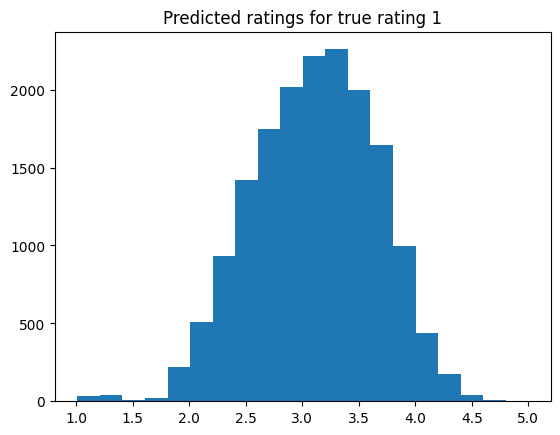

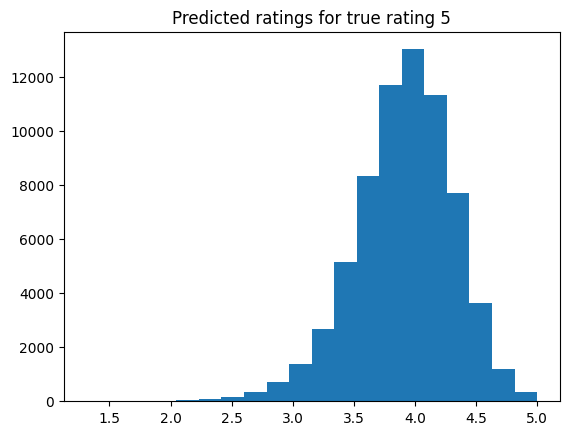

In [102]:
import matplotlib.pyplot as plt

plt.hist([test_pred_ratings[i] for i in range(len(test_pred_ratings)) if test['rating'][i] == 1], bins=20)
plt.title('Predicted ratings for true rating 1')
plt.show()

plt.hist([test_pred_ratings[i] for i in range(len(test_pred_ratings)) if test['rating'][i] == 5], bins=20)
plt.title('Predicted ratings for true rating 5')
plt.show()



I think that one of the drawbacks of NMF specifically for this problem (and probably any problem with sparse data) is that the missing values needs to be filled. In my case I used the user average ratings, and that affects the predictions, because all those values are used in calculations of the W and H matrices. There are other factorization techniques that can work better for such cases, like SGD (Stochastic Gradient Descent) which can ignore the NaN values.